In [1]:
import operator
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
import requests
from bs4 import BeautifulSoup
from datetime import datetime

d:\Agentic_AI\Day-7\VectorDB\FAISS\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain.schema import StrOutputParser

In [3]:
# Define the state
class GraphState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    question: str
    generation: str
    route: str
    validation_passed: bool
    retry_count: int
    routing_reasoning: str

Rag pipeline

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import os
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm=ChatGoogleGenerativeAI(model='gemini-2.5-flash')
output=llm.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [8]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

384

In [9]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [10]:
loader=DirectoryLoader("../data2",glob="./*.txt",loader_cls=TextLoader)

In [11]:
docs=loader.load()

In [12]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [13]:
new_docs=text_splitter.split_documents(documents=docs)

In [15]:
new_docs

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='innovation, global trade,

In [14]:
doc_string=[doc.page_content for doc in new_docs]

In [17]:
doc_string

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,',
 'It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a',
 'a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.',
 'innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.',
 'U.S. GDP – Size, Composition, and Global Share',
 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 

In [15]:
db=Chroma.from_documents(new_docs,embeddings)

In [16]:
retriever=db.as_retriever(search_kwargs={"k": 3})

In [17]:
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data2\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [ ]:
# Pydantic Models for Structured Output
class RouteSelection(BaseModel):
    route: str = Field(description="Selected route: 'rag', 'web_crawler', or 'llm'")
    reasoning: str = Field(description="Reasoning behind the route selection")

class ValidationResult(BaseModel):
    passed: bool = Field(description="Whether validation passed")
    reasoning: str = Field(description="Reasoning for validation decision")
    issues: str = Field(default="", description="Issues found if validation failed")

In [19]:
def supervisor_node(state: GraphState) -> GraphState:
    """
    Supervisor decides which node to route to based on the question
    """
    messages = state["messages"]
    retry_count = state.get("retry_count", 0)
    
    # Get the original question
    question = state["question"]
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor that routes questions to the appropriate processing node.
        
        Analyze the question and decide which node should handle it:
        - 'rag': Questions about USA context, history, general facts, or information that might be in documents
        - 'web_crawler': Questions about current USA news, recent events, or real-time information
        - 'llm': General questions, calculations, or other queries that don't fit the above
        
        Current date: {current_date}
        This is retry attempt: {retry_count}
        
        Provide your decision with clear reasoning.
        """),
        ("human", "Question: {question}")
    ])
    
    # Use structured output with Pydantic model
    structured_llm = llm.with_structured_output(RouteSelection)
    chain = supervisor_prompt | structured_llm
    
    response = chain.invoke({
        "question": question,
        "current_date": datetime.now().strftime("%Y-%m-%d"),
        "retry_count": retry_count
    })

    
    route = response.route.lower()
    
    # Ensure valid route
    if route not in ['rag', 'web_crawler', 'llm']:
        route = 'llm'
    
    # Return updated state with messages added
    return {
        "route": route,
        "routing_reasoning": response.reasoning,
        "messages": [
            SystemMessage(content=f"[Supervisor] Routing to: {route}"),
            SystemMessage(content=f"[Reasoning] {response.reasoning}")
        ]
    }


In [20]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [21]:
from langchain.schema.runnable import RunnablePassthrough

In [22]:
def rag_node(state: GraphState) -> GraphState:
    """
    RAG node - retrieves information from vector store/documents about USA
    """
    question = state.get("question", "")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a RAG assistant with access to documents about USA context, history, and facts.
        Answer the question based on the provided context from your knowledge base.
        
        If you don't have sufficient information in the context, say so clearly and suggest what information is needed.
        
        Context: {context}
        """),
        ("human", "{question}")
    ])
    
    # Build the RAG chain
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    # Fixed: using rag_chain instead of chain
    response = rag_chain.invoke(question)
    
    # Return updated state with messages added
    return {
        "generation": response,
        "messages": [
            AIMessage(content=response, name="RAG")
        ]
    }

In [43]:
def web_crawler_node(state: GraphState) -> GraphState:
    """
    Web crawler node - extracts real-time USA news from the internet
    """
    question = state.get("question", "")
    news_summary = ""  # Initialize at the start
    
    try:
        # Get NEWS_API_KEY
        news_api_key = os.getenv("NEWS_API_KEY")
        
        if news_api_key:
            # Option 1: Using News API
            url = f"https://newsapi.org/v2/top-headlines?country=us&q={question}&apiKey={news_api_key}"
            
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            
            response = requests.get(url, headers=headers, timeout=10)
            data = response.json()
            
            if data.get('status') == 'ok' and data.get('articles'):
                articles = data['articles'][:5]
                
                news_summary = "Here are the latest USA news articles related to your question:\n\n"
                for idx, article in enumerate(articles, 1):
                    news_summary += f"{idx}. {article.get('title', 'N/A')}\n"
                    news_summary += f"   Date: {article.get('publishedAt', 'N/A')}\n"
                    news_summary += f"   Source: {article.get('url', 'N/A')}\n"
                    if article.get('description'):
                        news_summary += f"   Summary: {article['description'][:200]}...\n"
                    news_summary += "\n"
            else:
                # If News API returns no articles, fallback to RSS
                news_api_key = None  # This will trigger RSS fallback below
        
        # Option 2: Using Google News RSS feed (if no API key or API failed)
        if not news_api_key or not news_summary:
            search_query = question.replace(" ", "+")
            url = f"https://news.google.com/rss/search?q={search_query}+USA&hl=en-US&gl=US&ceid=US:en"
            
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }
            
            response = requests.get(url, headers=headers, timeout=10)
            soup = BeautifulSoup(response.content, 'xml')
            
            # Extract news items
            items = soup.find_all('item', limit=5)
            news_items = []
            
            for item in items:
                title = item.find('title').text if item.find('title') else ""
                link = item.find('link').text if item.find('link') else ""
                pub_date = item.find('pubDate').text if item.find('pubDate') else ""
                description = item.find('description').text if item.find('description') else ""
                
                news_items.append({
                    'title': title,
                    'link': link,
                    'date': pub_date,
                    'description': description
                })
            
            if news_items:
                news_summary = "Here are the latest USA news articles related to your question:\n\n"
                for idx, item in enumerate(news_items, 1):
                    news_summary += f"{idx}. {item['title']}\n"
                    news_summary += f"   Date: {item['date']}\n"
                    news_summary += f"   Link: {item['link']}\n"
                    if item['description']:
                        news_summary += f"   Summary: {item['description'][:200]}...\n"
                    news_summary += "\n"
        
        # Check if we got any news
        if not news_summary:
            generation = "I couldn't find recent USA news articles related to your question. Please try rephrasing or ask about a different topic."
            return {
                "generation": generation,
                "messages": [AIMessage(content=generation, name="WebCrawler")]
            }
        
        # Use LLM to synthesize the answer based on news
        synthesis_prompt = ChatPromptTemplate.from_messages([
            ("system", """You are a news analyst. Based on the following news articles, 
            provide a comprehensive answer to the user's question about USA news.
            
            News Articles:
            {news_data}
            """),
            ("human", "{question}")
        ])
        
        chain = synthesis_prompt | llm
        llm_response = chain.invoke({
            "question": question,
            "news_data": news_summary
        })
        
        generation = llm_response.content
        
    except Exception as e:
        generation = f"I encountered an error while retrieving web information: {str(e)}. This could be due to network issues or the news source being temporarily unavailable. Please try again in a moment."
    
    # Return updated state with messages added
    return {
        "generation": generation,
        "messages": [
            AIMessage(content=generation, name="WebCrawler")
        ]
    }

In [44]:
def llm_node(state: GraphState) -> GraphState:
    """
    General LLM node for questions that don't need RAG or web crawling
    """
    question = state["question"]
    
    llm_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Answer the question clearly and concisely."),
        ("human", "{question}")
    ])
    
    chain = llm_prompt | llm
    response = chain.invoke({"question": question})
    
    # Return updated state with messages added
    return {
        "generation": response.content,
        "messages": [
            AIMessage(content=response.content, name="LLM")
        ]
    }


In [45]:
def validation_node(state: GraphState) -> GraphState:
    """
    Validates the generated response for quality, relevance, and accuracy
    """
    question = state.get("question", "")
    generation = state.get("generation", "")
    route = state.get("route", "")
    
    validation_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a validation expert that evaluates AI-generated answers for quality.
        
        Evaluate the answer based on these criteria:
        1. **Relevance**: Does the answer directly address the question asked?
        2. **Completeness**: Is the answer sufficiently detailed and comprehensive?
        3. **Accuracy**: Does the answer appear factually sound and consistent?
        4. **Clarity**: Is the answer well-structured and easy to understand?
        5. **Usefulness**: Would this answer satisfy the user's information need?
        
        The answer was generated by the '{route}' node.
        
        Determine if the answer PASSES or FAILS validation.
        If it fails, provide specific issues that need to be addressed.
        """),
        ("human", """Question: {question}
        
Answer to validate:
{answer}

Provide your validation decision.""")
    ])
    
    # Use structured output
    structured_llm = llm.with_structured_output(ValidationResult)
    chain = validation_prompt | structured_llm
    
    response = chain.invoke({
        "question": question,
        "answer": generation,
        "route": route
    })
    
    validation_passed = response.passed
    retry_count = state.get("retry_count", 0)
    
    # Return updated state with messages added
    if validation_passed:
        return {
            "validation_passed": True,
            "messages": [
                SystemMessage(content=f"[Validation] PASSED - {response.reasoning}")
            ]
        }
    else:
        return {
            "validation_passed": False,
            "retry_count": retry_count + 1,
            "messages": [
                SystemMessage(content=f"[Validation] FAILED - {response.reasoning}"),
                SystemMessage(content=f"[Issues] {response.issues}")
            ]
        }

In [46]:
workflow = StateGraph(GraphState)

In [47]:
# Add nodes
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("rag", rag_node)
workflow.add_node("web_crawler", web_crawler_node)
workflow.add_node("llm", llm_node)
workflow.add_node("validation", validation_node)

In [48]:
# Set entry point
workflow.set_entry_point("supervisor")

In [49]:
def route_after_supervisor(state: GraphState) -> Literal["rag", "web_crawler", "llm"]:
    """Route to the appropriate node based on supervisor's decision"""
    route = state.get("route", "llm")
    # Ensure valid route
    if route not in ["rag", "web_crawler", "llm"]:
        route = "llm"
    return route

def route_after_validation(state: GraphState) -> Literal["supervisor", "end"]:
    """Route based on validation result"""
    if state.get("validation_passed", False):
        return "end"
    elif state.get("retry_count", 0) >= 3:
        # Max retries reached, end with a message
        return "end"
    else:
        return "supervisor"

In [50]:
# Add conditional edges from supervisor
workflow.add_conditional_edges(
        "supervisor",
        route_after_supervisor,
        {
            "rag": "rag",
            "web_crawler": "web_crawler",
            "llm": "llm"
        }
    )
    

In [51]:
workflow.add_edge("rag", "validation")
workflow.add_edge("web_crawler", "validation")
workflow.add_edge("llm", "validation")

In [52]:
def route_after_validation(state: GraphState) -> Literal["supervisor", "end"]:
    """Route based on validation result"""
    if state["validation_passed"]:
        return "end"
    elif state.get("retry_count", 0) >= 3:
        # Max retries reached, end anyway
        state["generation"] = "Maximum retry attempts reached. Please rephrase your question or try again later."
        return "end"
    else:
        return "supervisor"

In [53]:
# Add conditional edges from validation
workflow.add_conditional_edges(
        "validation",
        route_after_validation,
        {
            "supervisor": "supervisor",
            "end": END
        }
    )

In [54]:
app = workflow.compile()

In [55]:
from IPython.display import Image, display

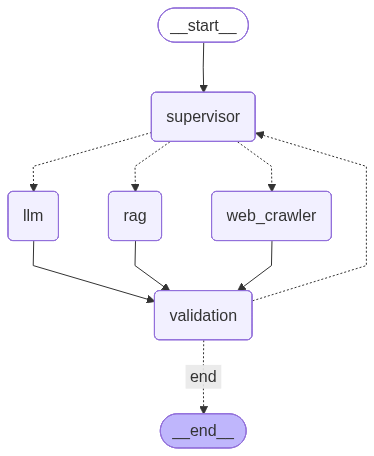

In [37]:
display(Image(app.get_graph().draw_mermaid_png()))

In [56]:
def run_workflow(question: str, verbose: bool = True):
    """Run the complete workflow with a question"""
    
    
    # Initialize state
    initial_state: AgentState = {
        "messages": [HumanMessage(content=question)],
        "question": question,
        "generation": "",
        "route": "",
        "validation_passed": False,
        "retry_count": 0,
        "routing_reasoning": ""
    }
    
    # Run the workflow
    result = app.invoke(initial_state)
    
    # Print execution trace if verbose
    if verbose:
        print("\n" + "="*80)
        print("EXECUTION TRACE")
        print("="*80)
        for msg in result["messages"]:
            if isinstance(msg, SystemMessage):
                print(f"\n🔧 {msg.content}")
            elif isinstance(msg, AIMessage):
                print(f"\n🤖 [{msg.name}]: {msg.content[:200]}...")
            elif isinstance(msg, HumanMessage):
                print(f"\n👤 User: {msg.content}")
        print("="*80 + "\n")
    
    return result

In [41]:
print("TEST 1: RAG Query (USA History)")
result1 = run_workflow("What do you know about USA economy?")
print(f"\n✅ FINAL ANSWER:\n{result1['generation']}")
print(f"\n📊 Metadata:")
print(f"   - Route: {result1['route']}")
print(f"   - Validation: {'✓ Passed' if result1['validation_passed'] else '✗ Failed'}")
print(f"   - Retries: {result1['retry_count']}")

TEST 1: RAG Query (USA History)

EXECUTION TRACE

👤 User: What do you know about USA economy?

🔧 [Supervisor] Routing to: rag

🔧 [Reasoning] The question is about the USA economy, which is a general fact about the USA and fits the 'rag' category for USA context, history, or general facts.

🤖 [RAG]: Based on the provided context, I know the following about the USA economy:

*   It is the largest economy in the world in terms of nominal GDP.
*   It is considered the most powerful economic force gl...

🔧 [Validation] PASSED - The answer accurately summarizes the information about the USA economy based on the provided context. It directly addresses the question, provides relevant details, and clearly indicates what information is not available in the given excerpt.


✅ FINAL ANSWER:
Based on the provided context, I know the following about the USA economy:

*   It is the largest economy in the world in terms of nominal GDP.
*   It is considered the most powerful economic force globally.
* 

In [59]:
print("TEST 2: Web Crawler Query (Current News)")
result2 = run_workflow("What is happenong in US today?")
print(f"\n✅ FINAL ANSWER:\n{result2['generation']}")
print(f"\n📊 Metadata:")
print(f"   - Route: {result2['route']}")
print(f"   - Validation: {'✓ Passed' if result2['validation_passed'] else '✗ Failed'}")
print(f"   - Retries: {result2['retry_count']}")

TEST 2: Web Crawler Query (Current News)

EXECUTION TRACE

👤 User: What is happenong in US today?

🔧 [Supervisor] Routing to: web_crawler

🔧 [Reasoning] The user is asking about current events in the US, which falls under the 'web_crawler' category for current news and real-time information.

🤖 [WebCrawler]: Based on the news articles provided, it's important to note that all of them are dated in the future (2025). Therefore, these articles do not describe events happening "today" (assuming today is befor...

🔧 [Validation] PASSED - The answer correctly identified that the provided news articles were for future dates (2025) and therefore could not answer what is happening 'today'. It then helpfully summarized the events scheduled for those future dates. This demonstrates good understanding of the query's intent and the limitations of the provided information, while still offering relevant details.


✅ FINAL ANSWER:
Based on the news articles provided, it's important to note that all of

In [65]:
result3 = run_workflow("what are the best foods to get at the morning?")
print(f"\n✅ FINAL ANSWER:\n{result3['generation']}")
print(f"\n📊 Metadata:")
print(f"   - Route: {result3['route']}")
print(f"   - Validation: {'✓ Passed' if result3['validation_passed'] else '✗ Failed'}")
print(f"   - Retries: {result3['retry_count']}")


EXECUTION TRACE

👤 User: what are the best foods to get at the morning?

🔧 [Supervisor] Routing to: llm

🔧 [Reasoning] The user is asking a general question about food recommendations, which does not require specific document retrieval or real-time web crawling. The LLM can directly answer this query.

🤖 [LLM]: The best morning foods provide sustained energy, keep you full, and offer essential nutrients to kickstart your day. Aim for a balance of protein, complex carbohydrates, healthy fats, and fiber.

Here...

🔧 [Validation] PASSED - The answer directly addresses the question, provides a comprehensive list of healthy morning food options with explanations, and includes key nutritional principles. The information is accurate, well-structured, and highly useful for someone seeking advice on breakfast foods.


✅ FINAL ANSWER:
The best morning foods provide sustained energy, keep you full, and offer essential nutrients to kickstart your day. Aim for a balance of protein, complex carbohy

In [67]:
print(f"\n✅ FINAL ANSWER:\n{result3['generation']}")


✅ FINAL ANSWER:
The best morning foods provide sustained energy, keep you full, and offer essential nutrients to kickstart your day. Aim for a balance of protein, complex carbohydrates, healthy fats, and fiber.

Here are some excellent choices:

1.  **Eggs:** Versatile and packed with high-quality protein, which helps with satiety and muscle health.
2.  **Greek Yogurt:** High in protein and often contains probiotics for gut health. Opt for plain and add your own fruit.
3.  **Oatmeal:** A fantastic source of complex carbohydrates and soluble fiber (beta-glucan), which provides sustained energy and helps lower cholesterol.
4.  **Berries (Blueberries, Raspberries, Strawberries):** Rich in antioxidants, vitamins, and fiber, and naturally sweet.
5.  **Whole-Wheat Toast or English Muffin:** Provides complex carbohydrates and fiber, especially when paired with healthy toppings.
6.  **Avocado:** Loaded with healthy monounsaturated fats, fiber, and various vitamins and minerals. Great on toast

In [68]:
print(f"\n✅ FINAL ANSWER:\n{result2['generation']}")


✅ FINAL ANSWER:
Based on the news articles provided, it's important to note that all of them are dated in the future (2025). Therefore, these articles do not describe events happening "today" (assuming today is before 2025).

However, if you're asking about what *will be happening* in the US on those future dates, the articles mention:

*   **October 29-30, 2025:** A potential deal for a TikTok sale could be reached.
*   **October 28, 2025:** Deloitte will be covering economic events for that week.
*   **October 8, 2025:** Harvard Kennedy School will be explaining why government shutdowns continue to occur in the United States.
*   **July 4, 2025:** Protests are planned across the US, referred to as an "economic blackout."
*   **April 18, 2025:** The Center for Strategic and International Studies (CSIS) will be addressing the state of U.S. humanitarian assistance and its future.
